# Import libraries

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from PIL import Image
import glob
from imutils import contours
import imutils
from imutils import perspective
from scipy.spatial import distance as dist

# Read Image

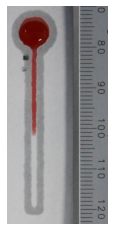

In [4]:
#read image
filename = glob.glob('../images/*.jpg')[15]
img = cv2.imread(filename)
#convert to rgb channel for display
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# display the rgb image
plt.axis('off')
plt.imshow(img)

(<matplotlib.axes._subplots.AxesSubplot at 0x7f514c176340>,
 <matplotlib.image.AxesImage at 0x7f514c1aee50>)

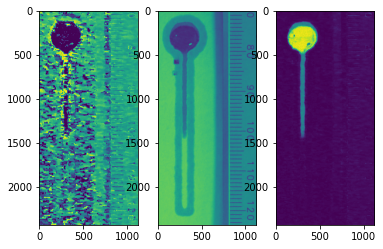

In [28]:
hls = cv2.cvtColor(img,cv2.COLOR_RGB2HLS)
plt.subplot(1,3,1),plt.imshow(hls[:,:,0])
plt.subplot(1,3,2),plt.imshow(hls[:,:,1])
plt.subplot(1,3,3),plt.imshow(hls[:,:,2])

(<matplotlib.axes._subplots.AxesSubplot at 0x7f514c1812e0>,
 <matplotlib.image.AxesImage at 0x7f514c1641f0>)

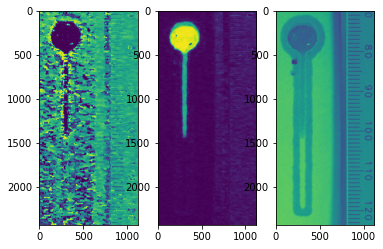

In [25]:
hsv = cv2.cvtColor(img,cv2.COLOR_RGB2HSV)
plt.subplot(1,3,1),plt.imshow(hsv[:,:,0])
plt.subplot(1,3,2),plt.imshow(hsv[:,:,1])
plt.subplot(1,3,3),plt.imshow(hsv[:,:,2])

In [6]:
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
gray.shape

(2436, 1122)

# Distribution of pixels in HSV space

NameError: name 'h' is not defined

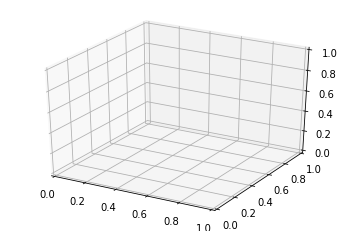

In [6]:
rgb = img.copy()
pixel_colors = rgb.reshape((np.shape(rgb)[0]*np.shape(rgb)[1], 3))
norm = colors.Normalize(vmin=-1.,vmax=1.)
norm.autoscale(pixel_colors)
pixel_colors = norm(pixel_colors).tolist()

fig = plt.figure()
axis = fig.add_subplot(1, 1, 1, projection='3d')

axis.scatter(h.flatten(), s.flatten(), v.flatten(),facecolors=pixel_colors,marker=".")
axis.set_xlabel("Hue")
axis.set_ylabel("Saturation")
axis.set_zlabel("Value")
plt.show()

# Segment image by red pixels

In [5]:
# segmentation by red pixels
# convert the image from bgr to hsv channels
# mask for lower range
hsv = cv2.cvtColor(img,cv2.COLOR_RGB2HSV)
lower_red = np.array([0,120,70])
upper_red = np.array([10,255,255])
mask1 = cv2.inRange(hsv, lower_red, upper_red)
 

# Mask for upper range
lower_red = np.array([170,120,70])
upper_red = np.array([180,255,255])
mask2 = cv2.inRange(hsv,lower_red,upper_red)
 

# Generating the final mask to detect red color
mask3 = mask1+mask2

In [6]:
# overlay combined mask onto original bgr image, return bright red pixels only
seg = cv2.bitwise_and(img,img,mask=mask3)


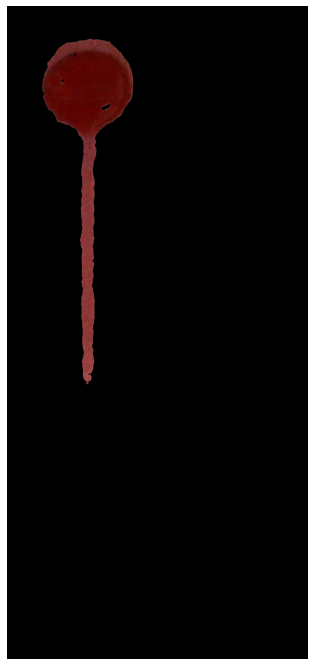

In [7]:
# display segmented pic
plt.figure(figsize=(20,12))
plt.axis('off')
# seg1 = cv2.cvtColor(seg, cv2.COLOR_BGR2RGB)
plt.imshow(seg)

# Find contours

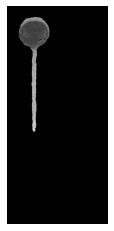

In [8]:
gray = cv2.cvtColor(seg, cv2.COLOR_RGB2GRAY)
plt.axis('off')
plt.imshow(gray,cmap='gray')

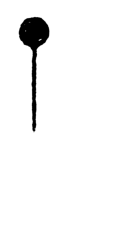

In [9]:
ret,thresh2 = cv2.threshold(gray,1,255,cv2.THRESH_BINARY_INV)
plt.axis('off')
plt.imshow(thresh2,cmap='gray')

In [10]:

edged = cv2.Canny(gray, 50, 100)
edged = cv2.dilate(edged, None, iterations=1)
edged = cv2.erode(edged, None, iterations=1)
# find contours in the edge map
cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL,
                        cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
# sort the contours from left-to-right and initialize the
# 'pixels per metric' calibration variable
# (cnts, _) = contours.sort_contours(cnts)
areas = []
for cnt in cnts:
    areas.append(cv2.contourArea(cnt))
# max_

In [11]:
cnt = cnts[np.argmax(areas)]

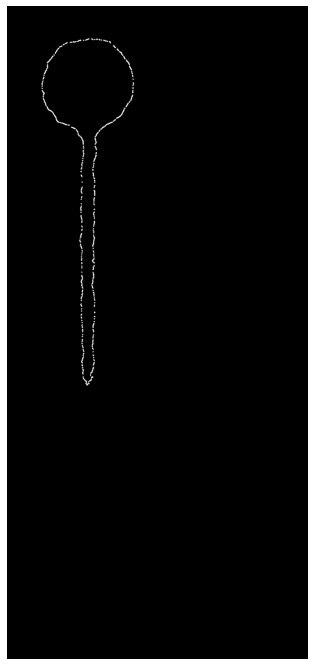

In [20]:
h,w,_ = img.shape
black = np.full((h,w,3),0.)
cnt_img = cv2.drawContours(black,cnt, -1, (1,1,1),3)
# cv2.circle(orig,(int(x),int(y)),5,(0,0,255),-1)

plt.figure(figsize=(20,12))
plt.axis('off')
plt.imshow(cnt_img)

In [24]:
cnt[:4]

array([[[305, 122]],

       [[304, 123]],

       [[302, 123]],

       [[301, 124]]], dtype=int32)

# TODO: 
1. Find out length of red patch
2. Find out angle of paper
3. Extrapolate the real length of red patch along paper

In [39]:
print(cnts[0].shape)
points = cnts[0].reshape(-1,2)
print(points.shape)

(1357, 1, 2)
(1357, 2)


In [81]:
from scipy.spatial import ConvexHull
from scipy.spatial.distance import cdist

points = cnts[0].reshape(-1,2)

# Returned 420 points in testing
hull = ConvexHull(points)

# Extract the points forming the hull
hullpoints = points[hull.vertices,:]

# Naive way of finding the best pair in O(H^2) time if H is number of points on
# hull
hdist = cdist(hullpoints, hullpoints, metric='euclidean')

# Get the farthest apart points
bestpair = np.unravel_index(hdist.argmax(), hdist.shape)

point1 = tuple(hullpoints[bestpair[0]])
point2 = tuple(hullpoints[bestpair[1]])
length = cdist(hullpoints[bestpair[0]].reshape(1,2),hullpoints[bestpair[1]].reshape(1,2),metric='euclidean')
length = length[0][0]
#Print them
print([length,point1,point2])

[1444.183160128936, (318, 119), (295, 1563)]


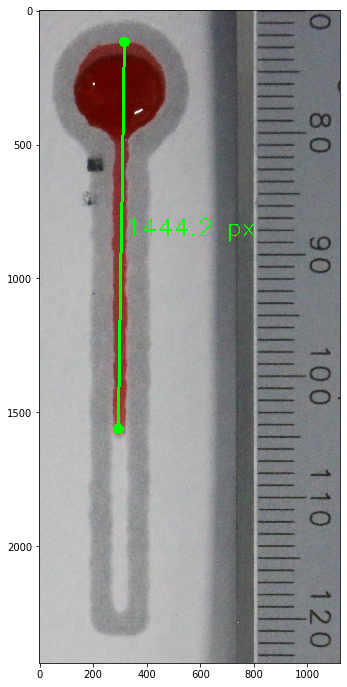

In [104]:
len_orig = img.copy()
# dist_img = cv2.drawContours(orig, cnts, -1, (0,255,0), 3)
cv2.circle(len_orig,point1,20,(0,255,0),-1)
cv2.circle(len_orig,point2,20,(0,255,0),-1)
cv2.line(len_orig,point1,point2,(0,255,0),10,-1)
midptX = int((point1[0]+point2[0])/2)
midptY = int((point1[1]+point2[1])/2)
# cv2.circle(len_orig,(midptX,midptY),20,(0,0,255),-1)
cv2.putText(len_orig, f"{length:.1f} px",
    (midptX + 15, midptY), cv2.FONT_HERSHEY_SIMPLEX,
    3, (0,255,0), 4)
plt.figure(figsize=(20,12))
plt.imshow(len_orig)

In [128]:
areas = []
for cnt in cnts:
    areas.append(cv2.contourArea(cnt))

In [129]:
areas

[142185.5, 4.0]

In [131]:
np.argmax(areas)

0